# 1 Imports

In [327]:
# imports

import os
import json
import math
import random
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
from items import Item
import matplotlib.pyplot as plt
import pickle
from collections import Counter

In [328]:
# More import for traditional Machine Learning

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [329]:
# And more imports for NLP related Machine Learning

from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import word2vec
from gensim.utils import simple_preprocess

In [330]:
# Imports for advanced Machine Learning

from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

In [331]:
# contrats
green = "\033[92m"
yellow = "\033[93m"
red = "\033[91m"
reset = "\033[0m"
color_map = {'red': red, 'yellow': yellow, 'green': green}

# 2 Connect to OpenAI & HuggingFace

In [332]:
# Load environment variables in a file called .env

load_dotenv()
api_key = os.getenv('OPEN_API_KEY')

In [333]:
# Load environment variables in a file called .env

load_dotenv()
hf_token = os.getenv('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


# 3 Load Dataset

In [334]:
with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

# 4 Tester ML

In [335]:
class Tester:

    def __init__(self, predictor, title=None, data=test, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error < 40 or error / truth < .2:
            return "green"
        elif error < 80 or error / truth < .4:
            return "yellow"
        else:
            return "red"
        
    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{color_map[color]}{i+1}: Guess: ${guess:,.2f} Truth ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{reset}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimation')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=='green')
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits ={hits/self.size*100:.1f}%"
        self.chart(title)
        
    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function):
        cls(function).run()

## 4.1 Random Prediction

In [336]:
def random_pricer(item):
    return random.randrange(1, 1000)

1: Guess: $655.00 Truth $59.99 Error: $595.01 SLE: 5.64 Item: Vic Firth Elementary Education Pack (inc...
2: Guess: $115.00 Truth $88.73 Error: $26.27 SLE: 0.07 Item: Samson Q6 Dynamic Microphone 3-Pack, Bla...
3: Guess: $26.00 Truth $26.59 Error: $0.59 SLE: 0.00 Item: Buckle-Down Guitar Strap Unicorn Univers...
4: Guess: $760.00 Truth $113.40 Error: $646.60 SLE: 3.59 Item: Kluson Revolution Tuners 3x3 No Collar L...
5: Guess: $282.00 Truth $60.99 Error: $221.01 SLE: 2.31 Item: EBXYA 1/4 TRS to XLR Male 6.5ft 6 Color ...
6: Guess: $251.00 Truth $19.99 Error: $231.01 SLE: 6.18 Item: Tesi IDO Super M 10mm Stainless Steel Ki...
7: Guess: $229.00 Truth $21.23 Error: $207.77 SLE: 5.46 Item: ICEPURE 5231JA2002A Refrigerator Water F...
8: Guess: $143.00 Truth $5.99 Error: $137.01 SLE: 9.15 Item: Kmise Round Head Strap Locks Straplocks ...
9: Guess: $755.00 Truth $3.99 Error: $751.01 SLE: 25.21 Item: FUPEI 9 Pcs Maple Syrup 1 Quart Filter S...
10: Guess: $105.00 Truth $80.00 Error: $25.00 SLE:

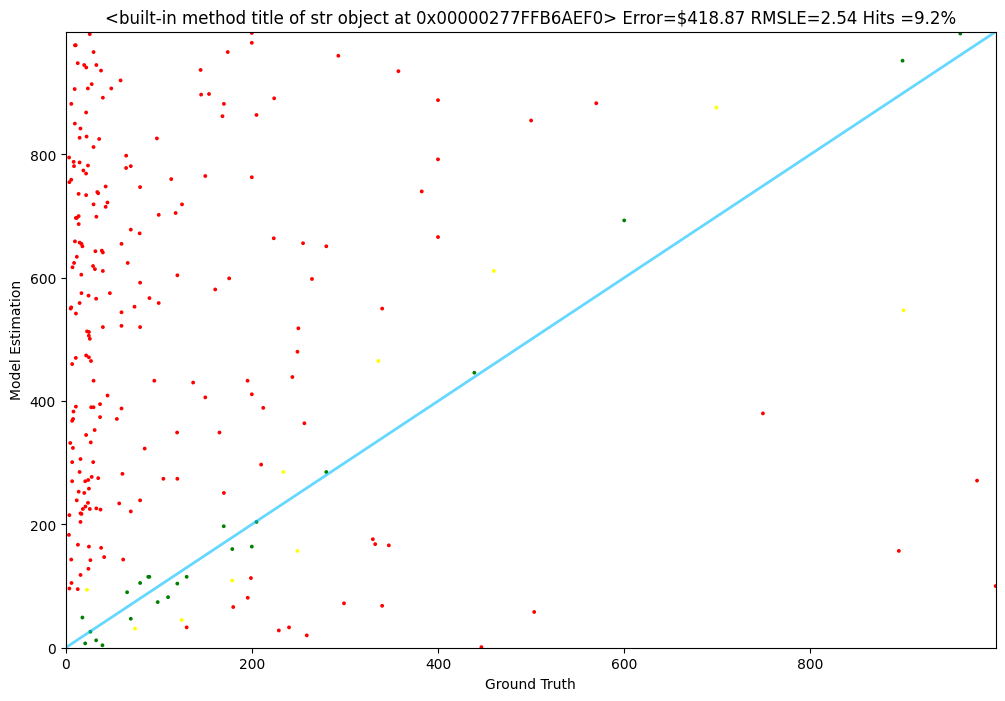

In [337]:
random.seed(42)

Tester.test(random_pricer)

## 4.2 Average Prediction

1: Guess: $106.47 Truth $59.99 Error: $46.48 SLE: 0.32 Item: Vic Firth Elementary Education Pack (inc...
2: Guess: $106.47 Truth $88.73 Error: $17.74 SLE: 0.03 Item: Samson Q6 Dynamic Microphone 3-Pack, Bla...
3: Guess: $106.47 Truth $26.59 Error: $79.88 SLE: 1.85 Item: Buckle-Down Guitar Strap Unicorn Univers...
4: Guess: $106.47 Truth $113.40 Error: $6.93 SLE: 0.00 Item: Kluson Revolution Tuners 3x3 No Collar L...
5: Guess: $106.47 Truth $60.99 Error: $45.48 SLE: 0.30 Item: EBXYA 1/4 TRS to XLR Male 6.5ft 6 Color ...
6: Guess: $106.47 Truth $19.99 Error: $86.48 SLE: 2.67 Item: Tesi IDO Super M 10mm Stainless Steel Ki...
7: Guess: $106.47 Truth $21.23 Error: $85.24 SLE: 2.48 Item: ICEPURE 5231JA2002A Refrigerator Water F...
8: Guess: $106.47 Truth $5.99 Error: $100.48 SLE: 7.47 Item: Kmise Round Head Strap Locks Straplocks ...
9: Guess: $106.47 Truth $3.99 Error: $102.48 SLE: 9.42 Item: FUPEI 9 Pcs Maple Syrup 1 Quart Filter S...
10: Guess: $106.47 Truth $80.00 Error: $26.47 SLE: 0.08

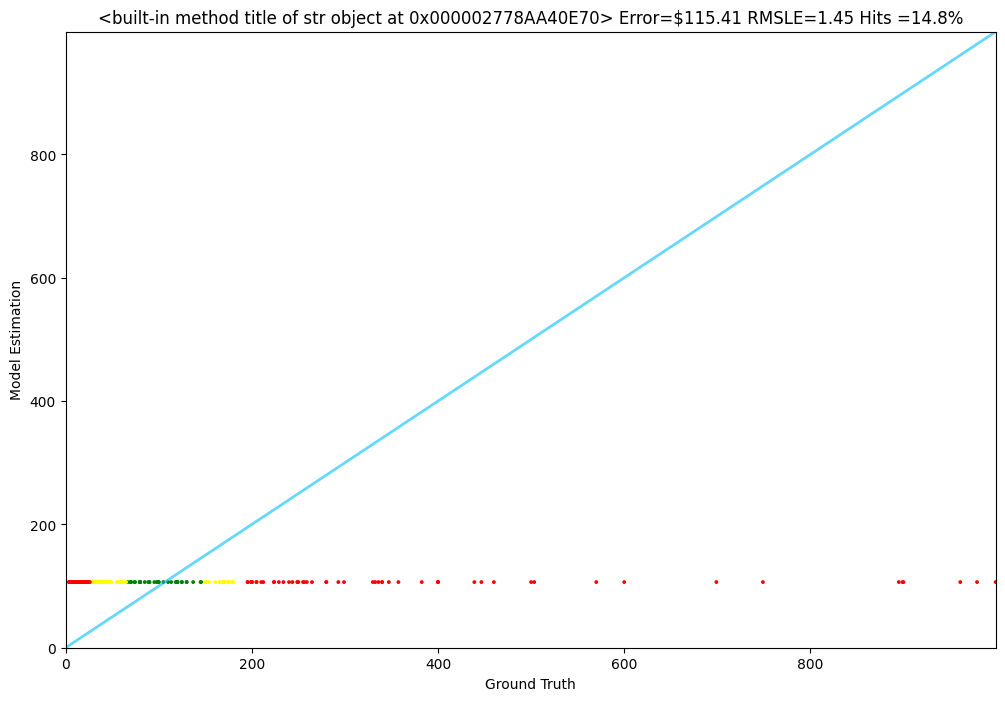

In [338]:
training_prices = [item.price for item in train]
training_average = sum(training_prices) / len(training_prices)

def constant_pricer(item):
    return training_average

Tester.test(constant_pricer)

# 5 Feature Engineering

## 5.1 Create a Feature info

In [339]:
# Create a new "features" field on items, and populate it with json parsed from the details dict

for item in train:
    item.features = json.loads(item.details)
for item in test:
    item.features = json.loads(item.details)

In [340]:
train[0].features

{'Item Weight': '3.49 pounds',
 'Product Dimensions': '10.3 x 10.2 x 9 inches',
 'Best Sellers Rank': {'Musical Instruments': 77003, 'Singing Bowls': 636},
 'Is Discontinued By Manufacturer': 'No',
 'Date First Available': 'August 15, 2018',
 'Body Material': 'Crystal',
 'Color Name': 'White',
 'Material Type': 'Suede',
 'Size': '8 inch A',
 'Color': 'White',
 'Brand': 'AMSUNBO',
 'Material': 'Suede',
 'Item Dimensions LxWxH': '10.3 x 10.2 x 9 inches'}

In [341]:
feature_count = Counter()
for item in train:
    for f in item.features.keys():
        feature_count[f] += 1

feature_count.most_common(40)

[('Date First Available', 71676),
 ('Item Weight', 64327),
 ('Best Sellers Rank', 62714),
 ('Item model number', 56062),
 ('Brand', 50026),
 ('Product Dimensions', 44456),
 ('Is Discontinued By Manufacturer', 35638),
 ('Color', 34096),
 ('Color Name', 28684),
 ('Manufacturer', 23592),
 ('Material', 20842),
 ('Package Dimensions', 20655),
 ('Material Type', 20246),
 ('Country of Origin', 18525),
 ('Part Number', 16532),
 ('Size', 15632),
 ('Item Dimensions LxWxH', 15234),
 ('Batteries Required?', 14584),
 ('Batteries Included?', 11916),
 ('Included Components', 11474),
 ('Style', 11344),
 ('Power Source', 10632),
 ('Compatible Devices', 9717),
 ('Special Feature', 9448),
 ('Connector Type', 7825),
 ('Body Material', 7698),
 ('Number of Strings', 7478),
 ('Model Name', 7135),
 ('Brand Name', 6416),
 ('Connectivity Technology', 6271),
 ('Item Package Quantity', 6207),
 ('Voltage', 5807),
 ('Finish Type', 5535),
 ('Domestic Shipping', 4968),
 ('International Shipping', 4968),
 ('Back Mater

## 5.2 Weight Conversion

In [342]:
def get_weight(item):
    weight_str = item.features.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit == 'pounds':
            return amount
        elif unit == 'ounces': 
            return amount / 16
        elif unit == 'grams':
            return amount / 453.592
        elif unit == 'milligrams':
            return amount / 453592
        elif unit == 'kilograms':
            return amount / .453592
        elif unit == 'hundredths' and parts[2].lower()=='pounds':
            return amount / 100
        else:
            print(weight_str)

    return None

In [343]:
weights = [get_weight(t) for t in train]
weights = [w for w in weights if w]

In [344]:
average_weight = sum(weights) / len(weights)
average_weight

4.426494020792581

In [345]:
def get_weight_pricer(item):
    weight = get_weight(item)
    return weight or average_weight

## 5.3 Best Sellers Rank

In [346]:
def get_rank(item):
    rank_dict = item.features.get('Best Sellers Rank')
    if rank_dict:
        ranks = rank_dict.values()
        return sum(ranks) / len(ranks)
    return None

In [347]:
ranks = [get_rank(t) for t in train]
ranks = [r for r in ranks if r]
average_rank = sum(ranks) / len(ranks)
average_rank

97803.78692809936

In [348]:
def get_rank_with_default(item):
    rank = get_rank(item)
    return rank or average_rank

## 5.4 Description Length

In [349]:
def get_text_length(item):
    return len(item.test_prompt())

## 5.5 Top Brand Identification

In [350]:
# Investigate the brands

brands = Counter()
for t in train:
    brand = t .features.get('Brand')
    if brand:
        brands[brand] += 1

brands.most_common(20)

[('Fender', 523),
 ('GE', 482),
 ('Frigidaire', 434),
 ('Whirlpool', 434),
 ('Upstart Battery', 406),
 ('Latin Percussion', 344),
 ('JIM DUNLOP', 344),
 ('Rockville', 343),
 ('Pyle', 339),
 ('WORLDS BEST CABLES', 282),
 ('Ibanez', 265),
 ('Yamaha', 262),
 ('Supplying Demand', 262),
 ('Seismic Audio', 254),
 ('Behringer', 251),
 ('Hohner Accordions', 249),
 ('Audio-Technica', 238),
 ('OnStage', 230),
 ('Musiclily', 223),
 ('SAMSUNG', 198)]

In [351]:
top_electronics_brands = ['Fender','GE','Frigidaire','Whirlpool','Upstart Battery','Latin Percussion','JIM DUNLOP','Rockville','Pyle','WORLDS BEST CABLES','Ibanez','Yamaha']
def is_top_electronics_brand(item):
    brand = item.features.get('Brand')
    return brand and brand.lower() in top_electronics_brands

## 5.6 Creation of Features

In [352]:
def get_features(item):
    return {
        'weight': get_weight_pricer(item),
        'rank': get_rank_with_default(item),
        'text_length': get_text_length(item),
        'is_top_electronics_brand': 1 if is_top_electronics_brand(item) else 0
    }

In [353]:
get_features(train[0])

{'weight': 3.49,
 'rank': 38819.5,
 'text_length': 756,
 'is_top_electronics_brand': 0}

In [354]:
def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df['price'] = [item.price for item in items]
    return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test[:250])

# 6 Machine Learning Modelling

## 6.1 Linear Regression

In [355]:
np.random.seed(42)

# Separate features and targets
feature_columns = [col for col in train_df.columns if col != 'price']
X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

feature_columns = ['weight', 'rank', 'text_length', 'is_top_electronics_brand']

X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef:.4f}")
print(f"Intercept: {model.intercept_:.4f}")

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

weight: 6.1892
rank: -0.0001
text_length: 0.0629
is_top_electronics_brand: 0.0000
Intercept: 38.0623
Mean Squared Error: 25102.61
R^2 Score: 0.24


In [358]:
def linear_regression_pricer(item):
    features = get_features(item)
    features_df = pd.DataFrame([features])
    return model.predict(features_df)[0]

1: Guess: $89.86 Truth $59.99 Error: $29.87 SLE: 0.16 Item: Vic Firth Elementary Education Pack (inc...
2: Guess: $95.66 Truth $88.73 Error: $6.93 SLE: 0.01 Item: Samson Q6 Dynamic Microphone 3-Pack, Bla...
3: Guess: $109.88 Truth $26.59 Error: $83.29 SLE: 1.93 Item: Buckle-Down Guitar Strap Unicorn Univers...
4: Guess: $81.42 Truth $113.40 Error: $31.98 SLE: 0.11 Item: Kluson Revolution Tuners 3x3 No Collar L...
5: Guess: $86.30 Truth $60.99 Error: $25.31 SLE: 0.12 Item: EBXYA 1/4 TRS to XLR Male 6.5ft 6 Color ...
6: Guess: $109.87 Truth $19.99 Error: $89.88 SLE: 2.77 Item: Tesi IDO Super M 10mm Stainless Steel Ki...
7: Guess: $87.63 Truth $21.23 Error: $66.40 SLE: 1.91 Item: ICEPURE 5231JA2002A Refrigerator Water F...
8: Guess: $87.84 Truth $5.99 Error: $81.85 SLE: 6.46 Item: Kmise Round Head Strap Locks Straplocks ...
9: Guess: $76.96 Truth $3.99 Error: $72.97 SLE: 7.56 Item: FUPEI 9 Pcs Maple Syrup 1 Quart Filter S...
10: Guess: $153.61 Truth $80.00 Error: $73.61 SLE: 0.42 Item: Lf

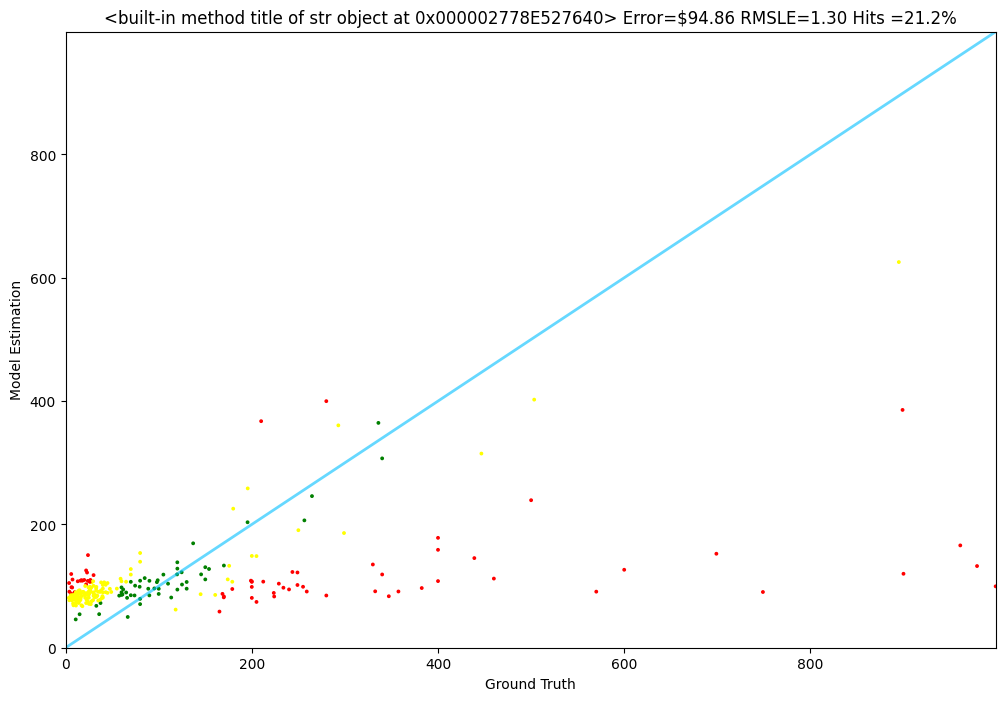

In [359]:
Tester.test(linear_regression_pricer)